Custom MobilenetV2

In [1]:
!git clone https://github.com/coick4698/garbage_classification.git

from google.colab import drive
drive.mount('/content/drive')

%cd /content/garbage_classification

import sys
sys.path.append('/content/garbage_classification/src')

from dataset import get_dataloaders
from train import train_model
from utils import plot_accuracy, plot_confusion_matrix, eval_precision_recall_f1

data_path = '/content/drive/MyDrive/iss_project/garbage_classification'

Cloning into 'garbage_classification'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 146 (delta 66), reused 32 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (146/146), 1.74 MiB | 6.23 MiB/s, done.
Resolving deltas: 100% (66/66), done.
Mounted at /content/drive
/content/garbage_classification


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 112MB/s] 


Epoch [1/10] Train Acc: 72.21%, Val Acc: 84.97%
Epoch [2/10] Train Acc: 82.24%, Val Acc: 86.21%
Epoch [3/10] Train Acc: 84.58%, Val Acc: 80.82%
Epoch [4/10] Train Acc: 87.59%, Val Acc: 85.51%
Epoch [5/10] Train Acc: 88.68%, Val Acc: 84.02%
Epoch [6/10] Train Acc: 89.85%, Val Acc: 87.91%
Epoch [7/10] Train Acc: 90.01%, Val Acc: 89.81%
Epoch [8/10] Train Acc: 90.85%, Val Acc: 85.11%
Epoch [9/10] Train Acc: 91.55%, Val Acc: 88.86%
Epoch [10/10] Train Acc: 92.96%, Val Acc: 89.11%


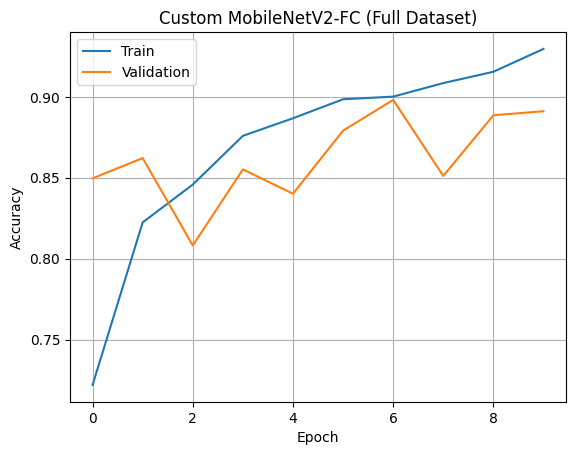

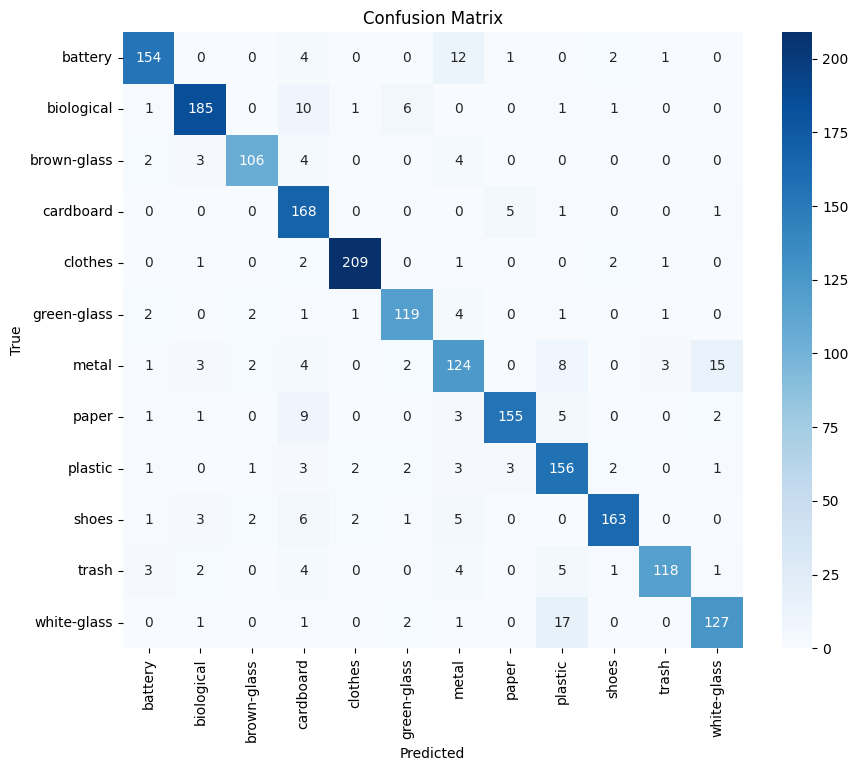

Classification Report:
              precision    recall  f1-score   support

     battery       0.93      0.89      0.91       174
  biological       0.93      0.90      0.92       205
 brown-glass       0.94      0.89      0.91       119
   cardboard       0.78      0.96      0.86       175
     clothes       0.97      0.97      0.97       216
 green-glass       0.90      0.91      0.90       131
       metal       0.77      0.77      0.77       162
       paper       0.95      0.88      0.91       176
     plastic       0.80      0.90      0.85       174
       shoes       0.95      0.89      0.92       183
       trash       0.95      0.86      0.90       138
 white-glass       0.86      0.85      0.86       149

    accuracy                           0.89      2002
   macro avg       0.89      0.89      0.89      2002
weighted avg       0.90      0.89      0.89      2002



In [ ]:
# Exp.1 - FC layer + Dropout + Activation Function
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2
import matplotlib.pyplot as plt
import cv2
import os

# 1. Define model
class CustomMobileNetV2_exp1(nn.Module):
    def __init__(self, num_classes=12):
        super(CustomMobileNetV2_exp1, self).__init__()
        base_model = mobilenet_v2(weights='IMAGENET1K_V1')
        self.features = base_model.features
        self.pool = nn.AdaptiveAvgPool2d(1)

        # FC layer: 1280 -> 256 -> 12
        # Dropout(0.2,0.3)
        # Activation Function(ReLU6 -> GELU)
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, 256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)

        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 2. load data
train_loader, val_loader, class_names = get_dataloaders(data_path, use_small=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 3. load model
model = CustomMobileNetV2_exp1(num_classes=12).to(device)
train_acc, val_acc = train_model(model, train_loader, val_loader, num_epochs=10, device=device)

# 4. Accuracy Plot
plot_accuracy(train_acc, val_acc, title="Custom MobileNetV2-Exp1")

# 5. Confusion Matrix
plot_confusion_matrix(model, val_loader, class_names, device=device)

# 6. Precision / Recall / F1-score
acc, report, y_true, y_pred = eval_precision_recall_f1(model, val_loader, class_names, device)

# 7. Save
torch.save(model.state_dict(), "results/checkpoints/custommobilenetv2_exp1_full_epoch10.pth")

In [ ]:
# Exp.2 - Transfer Learning Fine-tuning (partial)

import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

# 1. Define model (pretrained + custom head)
class CustomMobileNetV2_exp2(nn.Module):
    def __init__(self, num_classes=12):
        super().__init__()
        base = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        self.features = base.features
        self.pool = nn.AdaptiveAvgPool2d(1)

        # FC layer: 1280 -> 256 -> 12
        # Dropout(0.2,0.3)
        # Activation Function(ReLU6 -> GELU)
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, 256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 2. utilize boundary of fine-tuning
def set_finetune_mode(model: CustomMobileNetV2_exp2, mode="partial", unfreeze_last_blocks=2):
    """
    mode: 'freeze' | 'partial' | 'full'
    - freeze  : Freeze the entire backbone (use as feature extractor, train head only)
    - partial : Train only the last N blocks of the backbone
    - full    : Train the entire backbone
    """
    for p in model.features.parameters():
        p.requires_grad = False

    if mode == "full":
        for p in model.features.parameters():
            p.requires_grad = True
    elif mode == "partial":
        blocks = list(model.features.children())
        for m in blocks[-unfreeze_last_blocks:]:
            for p in m.parameters():
                p.requires_grad = True
    elif mode == "freeze":
        pass
    else:
        raise ValueError("mode should be one of {'freeze','partial','full'}")

# 3. load data
train_loader, val_loader, class_names = get_dataloaders(data_path, use_small=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 4. load model
model = CustomMobileNetV2_exp2(num_classes=12).to(device)

# 5. select fine-tuning mode
finetune_mode = "partial"                # Freeze the entire backbone (use as feature extractor, train head only)
set_finetune_mode(model, mode=finetune_mode, unfreeze_last_blocks=2)

# 6. Training
train_acc, val_acc = train_model(model, train_loader, val_loader, num_epochs=10, device=device)

# 7. Accuracy Plot
plot_accuracy(train_acc, val_acc, title="Custom MobileNetV2-Exp2")

# 8. Confusion Matrix
plot_confusion_matrix(model, val_loader, class_names, device=device)

# 9. Precision / Recall / F1-score
acc, report, y_true, y_pred = eval_precision_recall_f1(model, val_loader, class_names, device)

# 10. Save
torch.save(model.state_dict(), "results/checkpoints/custommobilenetv2_exp2_full_epoch10.pth")

In [ ]:
# Exp.3 - Transfer Learning Fine-tuning (full)

import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

# 1. Define model (pretrained + custom head)
class CustomMobileNetV2_exp3(nn.Module):
    def __init__(self, num_classes=12):
        super().__init__()
        base = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        self.features = base.features
        self.pool = nn.AdaptiveAvgPool2d(1)

        # FC layer: 1280 -> 256 -> 12
        # Dropout(0.2,0.3)
        # Activation Function(ReLU6 -> GELU)
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, 256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 2. utilize boundary of fine-tuning
def set_finetune_mode(model: CustomMobileNetV2_exp3, mode="partial", unfreeze_last_blocks=2):
    """
    mode: 'freeze' | 'partial' | 'full'
    - freeze  : Freeze the entire backbone (use as feature extractor, train head only)
    - partial : Train only the last N blocks of the backbone
    - full    : Train the entire backbone
    """
    for p in model.features.parameters():
        p.requires_grad = False

    if mode == "full":
        for p in model.features.parameters():
            p.requires_grad = True
    elif mode == "partial":
        blocks = list(model.features.children())
        for m in blocks[-unfreeze_last_blocks:]:
            for p in m.parameters():
                p.requires_grad = True
    elif mode == "freeze":
        pass
    else:
        raise ValueError("mode should be one of {'freeze','partial','full'}")

# 3. load data
train_loader, val_loader, class_names = get_dataloaders(data_path, use_small=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 4. load model
model = CustomMobileNetV2_exp3(num_classes=12).to(device)

# 5. select fine-tuning mode
finetune_mode = "full"                # Train the entire backbone
set_finetune_mode(model, mode=finetune_mode, unfreeze_last_blocks=2)

# 6. Training
train_acc, val_acc = train_model(model, train_loader, val_loader, num_epochs=10, device=device)

# 7. Accuracy Plot
plot_accuracy(train_acc, val_acc, title="Custom MobileNetV2-Exp3")

# 8. Confusion Matrix
plot_confusion_matrix(model, val_loader, class_names, device=device)

# 9. Precision / Recall / F1-score
acc, report, y_true, y_pred = eval_precision_recall_f1(model, val_loader, class_names, device)

# 10. Save
torch.save(model.state_dict(), "results/checkpoints/custommobilenetv2_exp3_full_epoch10.pth")

In [ ]:
# Exp.4 - Transfer Learning Fine-tuning (freeze)

import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

# 1. Define model (pretrained + custom head)
class CustomMobileNetV2_exp4(nn.Module):
    def __init__(self, num_classes=12):
        super().__init__()
        base = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        self.features = base.features
        self.pool = nn.AdaptiveAvgPool2d(1)

        # FC layer: 1280 -> 256 -> 12
        # Dropout(0.2,0.3)
        # Activation Function(ReLU6 -> GELU)
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, 256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 2. utilize boundary of fine-tuning
def set_finetune_mode(model: CustomMobileNetV2_exp4, mode="partial", unfreeze_last_blocks=2):
    """
    mode: 'freeze' | 'partial' | 'full'
    - freeze  : Freeze the entire backbone (use as feature extractor, train head only)
    - partial : Train only the last N blocks of the backbone
    - full    : Train the entire backbone
    """
    for p in model.features.parameters():
        p.requires_grad = False

    if mode == "full":
        for p in model.features.parameters():
            p.requires_grad = True
    elif mode == "partial":
        blocks = list(model.features.children())
        for m in blocks[-unfreeze_last_blocks:]:
            for p in m.parameters():
                p.requires_grad = True
    elif mode == "freeze":
        pass
    else:
        raise ValueError("mode should be one of {'freeze','partial','full'}")

# 3. load data
train_loader, val_loader, class_names = get_dataloaders(data_path, use_small=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 4. load model
model = CustomMobileNetV2_exp4(num_classes=12).to(device)

# 5. select fine-tuning mode
finetune_mode = "freeze"                # Freeze the entire backbone (use as feature extractor, train head only)
set_finetune_mode(model, mode=finetune_mode, unfreeze_last_blocks=2)

# 6. Training
train_acc, val_acc = train_model(model, train_loader, val_loader, num_epochs=10, device=device)

# 7. Accuracy Plot
plot_accuracy(train_acc, val_acc, title="Custom MobileNetV2-Exp4")

# 8. Confusion Matrix
plot_confusion_matrix(model, val_loader, class_names, device=device)

# 9. Precision / Recall / F1-score
acc, report, y_true, y_pred = eval_precision_recall_f1(model, val_loader, class_names, device)

# 10. Save
torch.save(model.state_dict(), "results/checkpoints/custommobilenetv2_exp4_full_epoch10.pth")